In [ ]:
!pip install torch torchvision scikit-learn matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.8kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.49MB/s]


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        # Encoder: 28x28 = 784 input, compress to latent_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        # Decoder: reconstruct from latent_dim
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Output between 0-1
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        x_recon = x_recon.view(-1, 1, 28, 28)
        return x_recon, z


In [ ]:
!pip install torchviz


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs, embeddings = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 0.9362
Epoch 2/10, Loss: 0.9254
Epoch 3/10, Loss: 0.9254
Epoch 4/10, Loss: 0.9254
Epoch 5/10, Loss: 0.9254
Epoch 6/10, Loss: 0.9254
Epoch 7/10, Loss: 0.9254
Epoch 8/10, Loss: 0.9254
Epoch 9/10, Loss: 0.9254
Epoch 10/10, Loss: 0.9254


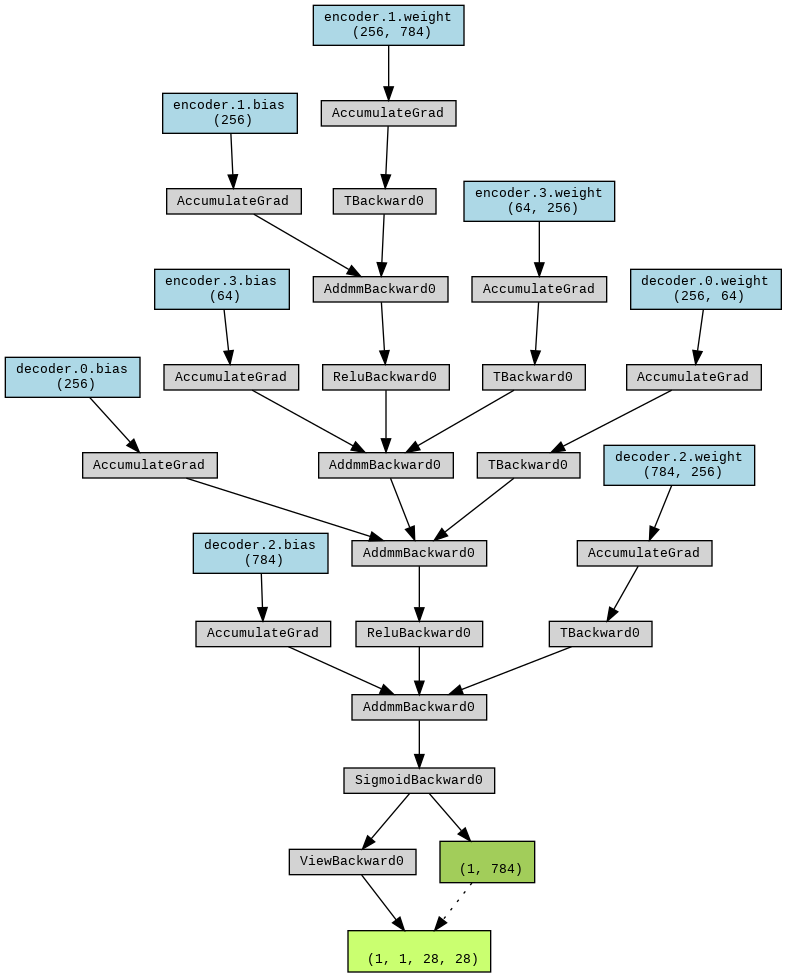

In [ ]:
from torchviz import make_dot
from IPython.display import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dummy_input = torch.randn(1, 1, 28, 28).to(device)
output, embeddings = model(dummy_input)

dot = make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('autoencoder_model_graph')

Image(filename='autoencoder_model_graph.png')


In [ ]:
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        _, embeddings = model(images)
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.append(labels.numpy())

all_embeddings = np.concatenate(all_embeddings)
all_labels = np.concatenate(all_labels)


In [ ]:
# Raw pixels flattened for first 1000 images (to save time)
raw_images, raw_labels = next(iter(DataLoader(train_dataset, batch_size=1000, shuffle=True)))
raw_images_flat = raw_images.view(1000, -1).numpy()

# KMeans on raw pixels
kmeans_raw = KMeans(n_clusters=10, random_state=0).fit(raw_images_flat)
sil_raw = silhouette_score(raw_images_flat, kmeans_raw.labels_)
db_raw = davies_bouldin_score(raw_images_flat, kmeans_raw.labels_)

# KMeans on latent embeddings (first 1000)
embeddings_sample = all_embeddings[:1000]
kmeans_latent = KMeans(n_clusters=10, random_state=0).fit(embeddings_sample)
sil_latent = silhouette_score(embeddings_sample, kmeans_latent.labels_)
db_latent = davies_bouldin_score(embeddings_sample, kmeans_latent.labels_)

print(f"Raw Image Clustering Silhouette Score: {sil_raw:.4f}, Davies-Bouldin Index: {db_raw:.4f}")
print(f"Latent Embedding Clustering Silhouette Score: {sil_latent:.4f}, Davies-Bouldin Index: {db_latent:.4f}")


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_sample)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=kmeans_latent.labels_, cmap='tab10', s=5)
plt.title("t-SNE Visualization of Clusters on Latent Embeddings")
plt.colorbar()
plt.show()
